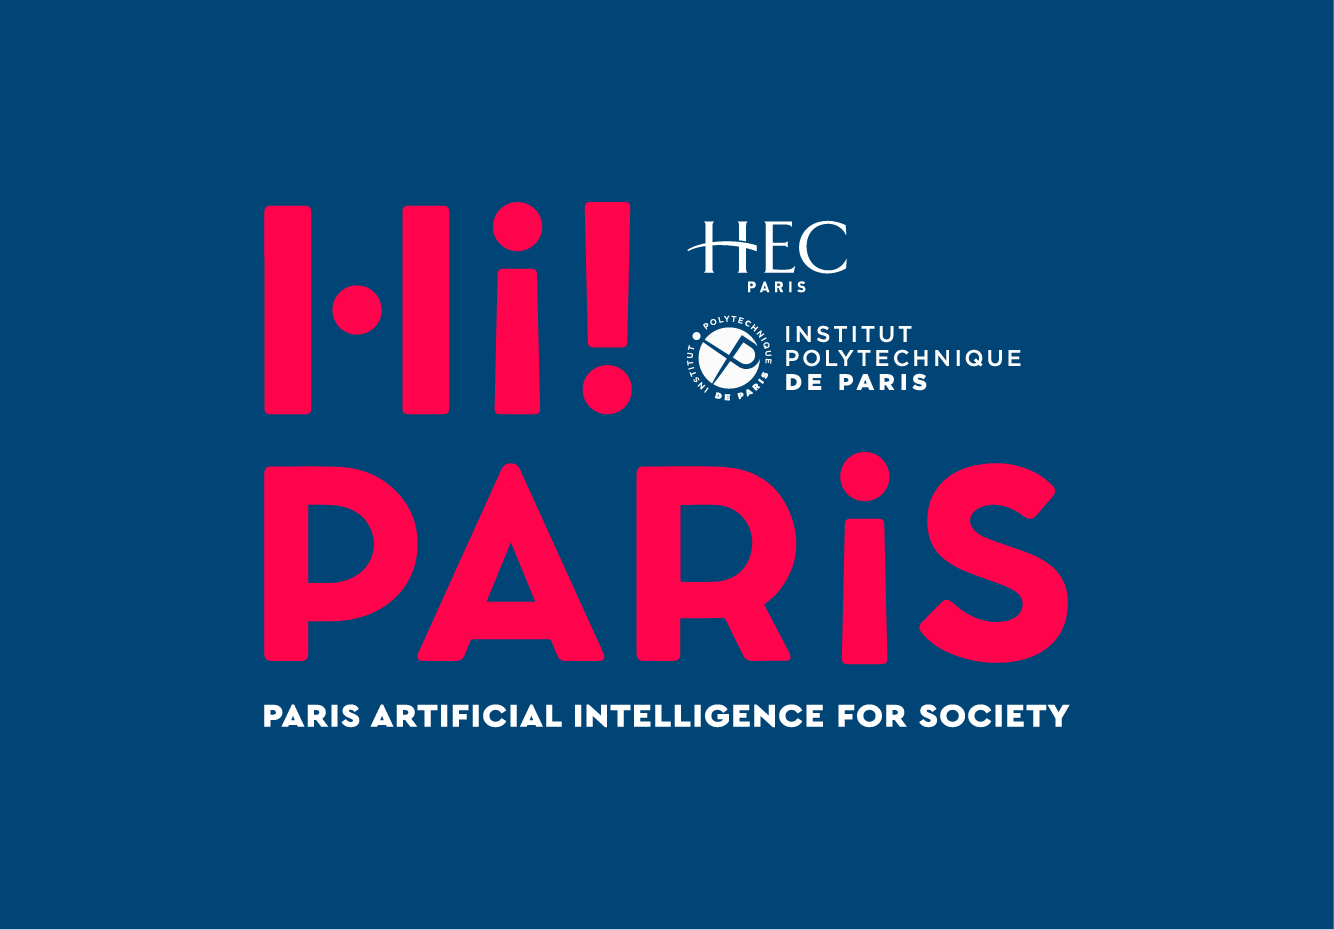

In [1]:
from IPython import display
display.Image("../src/figures/Hi!PARIS_logo_bleu.png")

<br>
<body>
    <p style="font-size:50px;text-align:center; color:#004475"><b><span style="color: #e61853">Hi!</span>ckathon 3</b></p><br>
    <p style="font-size:35px;text-align:center; color:#004475">Week 1 - Second Part :
    <p style="font-size:35px;text-align:center; color:#004475"> Exploratory data visualisation</p><br>
    <p style="font-size:25px;text-align:center; color:#004475">Estimated duration : 1h</p><br>
    <br><p style="font-size:15px;text-align:left; color:#004475"><b>Authors : Haddam Yacine, Ka Alioune, Renaud Adrien, Vizy Jean Nicolas and Calot Baptiste </b></p><br>
</body>
<br>

PART 2 : Exploratory_data_visualisation
======

### What is data exploration:
- Discovering early patterns in the data.
- Understand the first relationships of the variables.
- Initial analysis to discover where to go from here. 

### Why is it important? 
- Simplifies future analysis.
- Guides data analysis.
- Clean up data by removing unnecessary data. 

## 1. Building Metadata 

### Data Path

`data_dir` is the path to data folder.

In [ ]:
data_dir = "../data"

### Libraries

In [ ]:
import sys
import os
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sys.path.append('../src/notebooks')
from utils.get_data import load_data


pd.set_option('display.max_columns', 500)

In [ ]:
# Load cleaned data from previous notebook

building_meta, meters, weather = load_data('clean', data_dir=data_dir)

In [ ]:
building_meta

### How caracterises the primary use in each site id ?

In [ ]:
nbr_primary_use_by_site = (
    building_meta
    .pivot_table(index='site_id', columns='primary_use', values='building_id', aggfunc='count')
    .fillna(0)
)
nbr_primary_use_by_site

#### Tabular data are time consuming to analyze, heatmaps can simplify the insights reading

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
sns.heatmap(nbr_primary_use_by_site, annot=True, fmt='.0f', cbar=False, cmap="YlGnBu", linewidths=.5, ax=ax[0])
ax[0].set_title('Number of buildings per primary use for each site_id')


perc_primary_use_by_site = nbr_primary_use_by_site.div(nbr_primary_use_by_site.sum(axis=1), axis=0) * 100
sns.heatmap(perc_primary_use_by_site, annot=True, fmt='.0f', cbar=False, cmap="YlGnBu", linewidths=.5,  ax=ax[1])
ax[1].set_title('Percentage of buildings per primary use for each site_id')

_ = fig.suptitle('Statics of buildings per primary use for each site_id', fontsize=16)

## 2. Meters


#### Meter readings

- `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.
- `building_id`: unique identifier for the buildings.
- `meter_reading`: meter reading in kilowatt hour (kWh) .
- `meter`: meter type, `chilledwater`, `electricity`, `hotwater`, `steam`


The `meter` variable is encoded as an integer as follow:
```json
{0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
```

In [ ]:
dict_meter_name = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

In [ ]:
meters.head()

In [ ]:
meters.info()

### Study the distribution of the variable 'meter_reading'

We plot the distribution of `meter_reading` in linear and log scale.

In [ ]:
meters['log_meter_reading'] = np.log(meters.meter_reading + 1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
for meter, color in zip([0, 1, 2, 3], ['green', 'black', 'red', 'blue']):
    sns.distplot(
        meters.loc[meters.meter == meter, 'meter_reading'],
        ax=ax[0],
        hist=False,
        color=color
    )
    sns.distplot(
        meters.loc[meters.meter == meter, 'log_meter_reading'],
        ax=ax[1],
        hist=False,
        color=color
    )

ax[0].title.set_text('Distribution of meter reading')
ax[1].title.set_text('Distribution of log meter reading')

_ = fig.legend(labels=list(dict_meter_name.values()))

To reduce outliers effect, change the scale of the variable can be a solution!  
Another solution is to work with robust statistics (median).

We now visualize the evolution of `meter_reading`.

In [ ]:
plt.figure(figsize=(12, 6))
_ = (
    meters
    .set_index('timestamp')
    .resample("D")
    .meter_reading
    .mean()
    .plot()
    .set_ylabel('Mean meter reading', fontsize=13)
)
plt.grid()
plt.show()

The evolution looks strange, with huge consumption up to July 2016 and a spike in November.  
We need to investigate this behavior. 

We wants to plot the evolution of `meter_reading` by `site_id`.    
For this we need to enrich the meters DataFrame with the building metadata.

We create a new `pandas.DataFrame` named `dataset` by joining the `building_meta` and `meters` tables using the `building_id` key.

In [ ]:
dataset = building_meta.merge(meters, how='inner', on='building_id')

In [ ]:
def daily_plot_of_meter_reading(data, by, r=8, col=True):
    '''Plot daily consumption (`meter_reading` variable).

    Args:
        data (pd.DataFrame): datframe containg `meter_reading`.
        by (str): The name of the column to group by.
        r (int): the number of rows to plot
        col (bool): to draw in two columns
    '''
    if col:
        fig, axes = plt.subplots(r, 2, figsize=(14, 30), dpi=100)
        for i, val in enumerate(data['{}'.format(by)].unique()):
            try:
                i = int(val)
            except:
                pass
            (
                data[data['{}'.format(by)] == val]
                [['timestamp', 'meter_reading']]
                .set_index('timestamp')
                .resample('D')
                .mean()['meter_reading']
                .plot(ax=axes[i % r][i//r], alpha=0.8, label='By day', color='tab:blue')
                .set_ylabel('Mean meter reading', fontsize=13)
            )
            axes[i % r][i//r].legend()
            axes[i % r][i//r].set_title('{} {}'.format(by, val), fontsize=13)
            plt.subplots_adjust(hspace=0.45)
    else:
        fig, axes = plt.subplots(r, 1, figsize=(14, 30), dpi=100)
        for i, val in enumerate(data['{}'.format(by)].unique()):
            try:
                i = int(val)
            except:
                pass
            (
                data[data['{}'.format(by)] == val]
                [['timestamp', 'meter_reading']]
                .set_index('timestamp')
                .resample('D')
                .mean()['meter_reading']
                .plot(ax=axes[i], alpha=0.8, label='By day', color='tab:blue')
                .set_ylabel('Mean meter reading', fontsize=13)
            )
            axes[i].set_title('{} {}'.format(by, val), fontsize=13)

In [ ]:
daily_plot_of_meter_reading(dataset, "site_id")

According to these plot, what can you say about the site number 13?
take a closer look and plot the energy consumption on site number 13 by primary use.

**hint** : use hourly_plot_of_meter_reading() with the right filtered data and r = 5

what do you remark?

In [ ]:
daily_plot_of_meter_reading(dataset[dataset.site_id == 13], "primary_use", r=5)

We can see that the behavior is coming from building having `primary_use` equal to Education.

Lets see the mean `meter_reading` for those buildings.

In [ ]:
_ = (
    dataset
    [(dataset.site_id == 13) & (dataset.primary_use == "Education")]
    .groupby('building_id')
    .meter_reading
    .mean()
    .plot.bar()
)

By comparing the distribution of the energy consumption of building *1099* with others, we observe an abnormal behavior. Let's see the effect of that on our first plot of the evolution of `meter_reading`. 

In [ ]:
# create the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 20), dpi=100)

# plot only building 1099
(
    dataset
    [dataset['building_id'] == 1099]
    .set_index('timestamp')
    .resample('D')
    .meter_reading
    .mean()
    .plot(ax=axes[0])
)

# plot the all dataset
(
    dataset
    .set_index('timestamp')
    .resample('D')
    .meter_reading
    .mean()
    .plot(ax=axes[1])
)

# plot the all dataset excepted building 1099
(
    dataset
    [dataset['building_id'] != 1099]
    .set_index('timestamp')
    .resample('D')
    .meter_reading
    .mean()
    .plot(ax=axes[2])
)

# add some style
axes[0].set_title('building_id 1099', fontsize=13)
axes[1].set_title('Full dataset', fontsize=13)
axes[2].set_title('Full dataset with building_id 1099 excluded', fontsize=13)
plt.subplots_adjust(hspace=0.3)

In the following, it may be wise to remove this building so as not to bias the analyzes that will follow ( models or insights).

### There is a difference of energy consumption between type of buildings

In [ ]:
# create the figure
fig, ax = plt.subplots(figsize=(13, 7))

# loop over `primary_use` values and plot
for primary_use in dataset.primary_use.unique():
    sns.distplot(
        dataset.loc[dataset.primary_use == primary_use, 'log_meter_reading'],
        ax=ax,
        hist=False
    )

# add style
ax.title.set_text('Distribution of meter reading')
_ = fig.legend(labels=dataset.primary_use.unique())

The last visualisation is a little bit difficult to understand, we propose an other type of visualisation 'box plot'.

Box plot are perfect to detect outliers and comapre differents categories

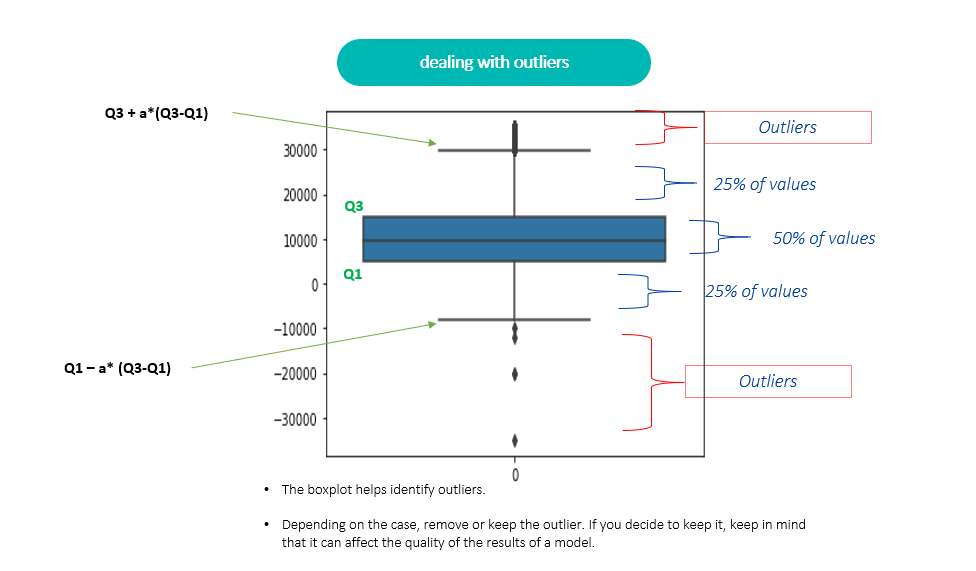

In [2]:
display.Image("../src/figures/Capture.png")

In [ ]:
f, ax = plt.subplots(figsize=(13, 7))

sns.boxplot(data=dataset, x='primary_use', y='log_meter_reading', ax=ax)
ax.set_ylabel('log meter reading (kWh)')
ax.set_xlabel('Primary usage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

_ = f.suptitle('Meter reading by primary_use', fontsize=20)

### How about site_id ?

Get the median consumption for each site (while keeping geo position): 

In [ ]:
site_median_consumption = (
    dataset
    .groupby(['site_id', 'lat', 'lng'])
    ['log_meter_reading']
    .median()
    .reset_index()
)

Plot site median consumption on a map:

In [ ]:
fig = px.scatter_mapbox(
    site_median_consumption,
    lat="lat", lon="lng",
    hover_name="site_id",
    color='log_meter_reading', size='log_meter_reading',
    color_discrete_sequence=["fuchsia"], zoom=2, height=300
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

## Time of Day and Meter Reading
Reading are significantly higher during  work hours and this is to be expected. Time of day appears like it will be a significant predictor in any subsequent model for this competition.

Create a numerical variable from date format data

In [ ]:
# create datetime related features to simplify the analysis

dataset['meter_name'] = dataset.meter.map(dict_meter_name)
dataset['day'] = dataset.timestamp.dt.day.astype(np.int8)
dataset['month'] = dataset.timestamp.dt.month.astype(np.int8)
dataset['hour'] = dataset.timestamp.dt.hour.astype(np.int8)
dataset['day_of_week'] = dataset.timestamp.dt.dayofweek.astype("int8")

In [ ]:
meters_by_hour = (
    dataset
    .groupby('hour')
    .agg({'log_meter_reading': 'median'})
)

fig, ax = plt.subplots(figsize=(11, 5))
sns.lineplot(data=meters_by_hour, x="hour", y="log_meter_reading", ax=ax)
_ = ax.set(title="Time of Day's Meter Reading Distribution")

### Is there a relation between the weather and meter_reading ?

To answer this question, we need to enrich our dataset with the `weather` table.  
To do this, we join the two tables using as key the two following variables: `site_id` and `timestamp`. 

In [ ]:
dataset = dataset.merge(
    weather,
    how='inner',
    on=['site_id', 'timestamp']
)

Get some info on the newly created table:

In [ ]:
dataset.info()

Measure the **correlations** between the **weather** variables and the **energy consumption**.

In [ ]:
def plot_weather_correlations(data):
    """Plot the correlations between weather data
    and the energy consumption.
    """

    columns_to_show = [
        "log_meter_reading",
        "air_temperature",
        "cloud_coverage",
        "dew_temperature",
        "precip_depth_1_hr",
        "sea_level_pressure",
        "wind_direction",
        "wind_speed"
    ]

    correlations = (
        data
        [columns_to_show]
        .corr(method="spearman")
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    _ = sns.heatmap(
        correlations,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        annot=True,
        ax=ax,
    )
    plt.xticks(rotation=45)
    _ = plt.show()

In [ ]:
plot_weather_correlations(dataset)

No correlation between the weather and the energy consumption? Really?

## Save dataset for the next notebook

In [ ]:
dataset.to_feather(
    os.path.join(data_dir, "merged/data.feather")
)

# It's your turn ! 

It's your turn to produce some meaningful visualization or insights from the final dataset.

Some possible visualizations: 
1. The impact of weather for the different energy sources.
2. Compare the energy consumption between two primary usage ( Education / Parking) during week days / weekend / holidays / season
3. Study the difference of energy consumption between geographical region

In [ ]:
# TODO 1

In [ ]:
plot_weather_correlations(dataset[dataset.meter_name == "steam"])


In [ ]:
# TODO 2

In [ ]:
def plot_meter_by(data, primary_use_1, primary_use_2, by):
    """Plot the energy consumption with respect to the variable `by`
    for two `primary_use` side by side.
    """
    fig, ax = plt.subplots(1, 2, figsize=(13, 7))
    educ_meters_by_hour = data[data.primary_use == primary_use_1].groupby(by).agg({'meter_reading': 'median'})
    park_meters_by_hour = data[data.primary_use == primary_use_2].groupby(by).agg({'meter_reading': 'median'})

    sns.lineplot(data=educ_meters_by_hour, x=by, y="meter_reading", marker="o", ax=ax[0])
    sns.lineplot(data=park_meters_by_hour, x=by, y="meter_reading", marker="o", ax=ax[1])

    ax[0].title.set_text('Distribution of log meter reading on Education buildings')
    ax[1].title.set_text('Distribution of log meter reading on Parking area')
    _ = plt.plot()


plot_meter_by(dataset, "Education", "Parking", by="hour")

In [ ]:
# TODO 3

In [ ]:
dataset["zone_geo"] = "US"
dataset.loc[dataset.lng > -4, 'zone_geo'] = "EUROPE"

dataset[["zone_geo", "log_meter_reading"]].groupby('zone_geo').describe().reset_index()

## Take away 
- The stronger the correlation coefficient between two variables, the more dependent they are
- Two highly dependent variables provide the same information
- Data exploration allows to estimate the relevance of some variables to answer the initial objective
- It is important to try to interpret and translate the observations into business terms
- Confusing correlation with causation
- Not taking proportions into account


### Go Further :
[COMPREHENSIVE DATA EXPLORATION WITH PYTHON](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)



# You can go to the next notebook which concerns the features engineering and modeling !
